# Introduction

I've simulated data for a real estate company with these defining characteristics:

- Location: based in San Francisco to provide constraints for prices and zipcodes
- Zipcodes: only covering zipcodes from 94101 to 94110 to constraint amount of offices
- Office Count: has exactly one office for every zipcode, each aptly named f"Office_{zipcode}"
- Agent Count: there are around 10 agents working for this company, some working for multiple offices
- Agent Rows: there are multiple entries for the same agent depending on the office they work for
- Listing Start Date: listing only started at January 2019, and this data only covers up to the end of December 2019
- Sales: only 70% of listed houses are sold to better simulate real conditions
- Sale Price: because of my unfamiliarity with the trends in sale price vs list price, I've decided to make them the same for now
- Commissions: commission is calculated for every sale
- Monthly reports: monthly "reports" are being presented except for December, because this theoretically being presented during "December"

# Code Implementation

See Appendix for code behind simulated data

In [1051]:
import sqlalchemy 
from sqlalchemy import create_engine, Column, Text, String, Date, Integer, Numeric, Boolean, ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker 

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import names
import os

engine = create_engine('sqlite:///db_cs162.db')
engine.connect()

Base = declarative_base() 

# Location: San Francisco
# Zipcode w/ one office each: 94101 -> 94110
# Agents: 20; 
# Jean, Mark, James, Tanner, Mike, Kane, Adam, Chelsea, Sam, Alex,
# Zane, Jack, Jake, Kennedy, Amanda, Kean, Tabatha, Hiro, Ken, Dave
# Time span: January 2019 to December 2019

class Offices(Base):
    __tablename__ = "Offices"
    id = Column(Integer, primary_key = True)
    name = Column(String(20))
    zipcode = Column(Integer)

# Can have multiple rows for multiple agents with multiple offices
class Agents(Base):
    __tablename__ = "Agents"
    id = Column(Integer, primary_key = True)
    name = Column(String(20))
    email_address = Column(String(40))
    office_id = Column(Integer, ForeignKey('Offices.id'))

class Customers(Base):
    __tablename__ = "Customers"
    id = Column(Integer, primary_key = True)
    name = Column(String(20))

class ListedHouses(Base):
    __tablename__ = "ListedHouses"
    id = Column(Integer, primary_key = True)
    agent_id = Column(Integer, ForeignKey('Agents.id'))
    office_id = Column(Integer, ForeignKey('Offices.id'))
    customer_id = Column(Integer, ForeignKey('Customers.id'))
    size = Column(Integer)
    bedroom_count = Column(Integer)
    bathroom_count = Column(Integer)
    zipcode = Column(Integer)
    condition = Column(Integer)
    price = Column(Numeric(precision=9,decimal_return_scale=2))
    list_date = Column(Date)
    sold = Column(Boolean)
    
class Sales(Base):
    __tablename__ = "Sales"
    id = Column(Integer, primary_key = True)
    house_id = Column(Integer, ForeignKey('ListedHouses.id'))
    customer_id = Column(Integer, ForeignKey('Customers.id'))
    sale_date  = Column(Date)
    sale_price = Column(Numeric(precision=9,decimal_return_scale=2), ForeignKey('ListedHouses.price'))
    
# Individual commissions!
class Commissions(Base):
    __tablename__ = "Commissions"
    id = Column(Integer, primary_key = True)
    agent_id = Column(Integer, ForeignKey('Agents.id'))    
    commission = Column(Integer)

Base.metadata.create_all(bind=engine)

# Simulate Data

In [995]:
Session = sessionmaker(bind=engine)
session = Session()

# Create one office per zipcode
for zipcode in range(94101, 94111):
    session.add(Offices(name=f"Office_{zipcode}", zipcode=zipcode))

try:
    session.commit()

except:
    session.rollback()
    raise

finally:
    session.close()

In [916]:
agent_offices

{0: [4],
 1: [9, 3, 4],
 2: [2, 4, 8],
 3: [6, 5, 4],
 4: [7, 2],
 5: [1, 2, 3],
 6: [10, 4, 3],
 7: [2],
 8: [8],
 9: [7, 8]}

In [990]:
agents = []
while len(agents) != 10:
    new_agent = names.get_first_name()
    if new_agent not in agents:
        agents.append(new_agent)
        
agents

['Erin',
 'Bertha',
 'Sara',
 'Maria',
 'Francisco',
 'Debrah',
 'Carolyn',
 'Joe',
 'Karen',
 'Jason']

In [996]:
Session = sessionmaker(bind=engine)
session = Session()

# Simulate agents
for agent in agents:
    for office_id in agent_offices[i]:
        session.add(Agents(name=agent, 
                           email_address=f'{agent}@yahoo.com', 
                           office_id=office_id))

try:
    session.commit()

except:
    session.rollback()
    raise

finally:
    session.close()

In [997]:
Session = sessionmaker(bind=engine)
session = Session()

# List Houses
for d in data:
    customer = names.get_first_name()
    
    if session.query(Customers.name).filter_by(name=customer).first() == None:
        session.add(Customers(name=customer))
    
    session.add(ListedHouses(agent_id=d['agent_id'], 
                            office_id=d['office_id'], 
                            customer_id=session.query(Customers.id).filter_by(name=customer).first()[0],
                            size=d['size'], 
                            bedroom_count=d['bedroom_count'],
                            bathroom_count=d['bathroom_count'],
                            zipcode=d['zipcode'],
                            condition=d['condition'],
                            price=d['price'],
                            list_date=d['list_date']))

try:
    session.commit()

except:
    session.rollback()
    raise

finally:
    session.close()

In [998]:
'''
Function to determine sale of every listed house

Every sale counts as one transaction where

Start:
    session = Session()
End:
    session.close()
'''

Session = sessionmaker(bind=engine)
session = Session()

# Sell Houses
for i in range(1,len(data)+1):
    
    house = session.query(ListedHouses.id, 
                          ListedHouses.customer_id,
                          ListedHouses.list_date,
                          ListedHouses.price).filter_by(id=i).first()
    
    # randomization to simulate how not all houses are sold
    if random.random()<0.7:
        session.add(Sales(house_id=house[0],
                         customer_id=house[1],
                         sale_date=house[2]+timedelta(random.uniform(5,90)),
                         sale_price=house[3]))

        session.query(ListedHouses).filter_by(id=i).first().sold = True

try:
    session.commit()

except:
    session.rollback()
    raise

finally:
    session.close()

# Querying Data

In [977]:
from sqlalchemy import func

Session = sessionmaker(bind=engine)
session = Session()

#### 1. Find the top 5 offices with the most sales for that month.

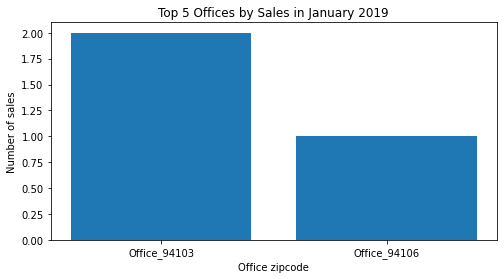

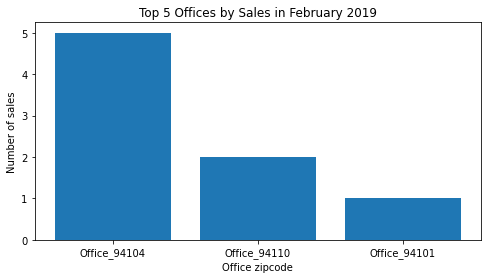

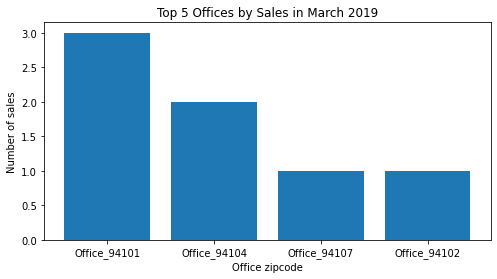

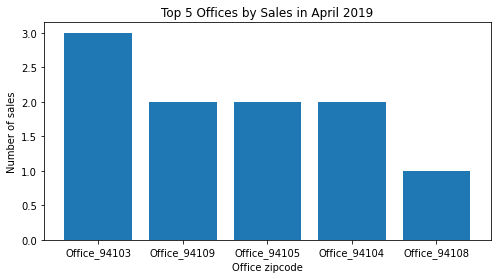

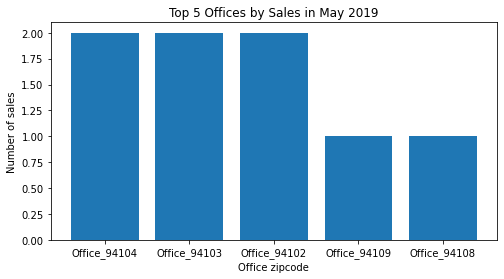

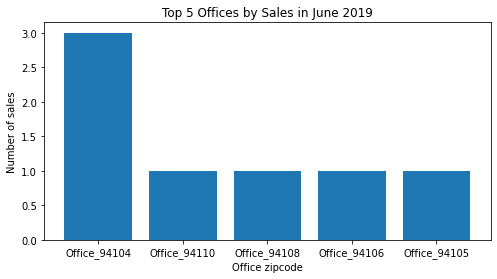

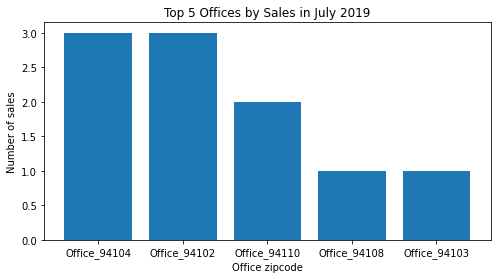

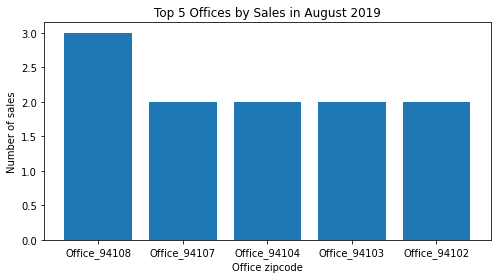

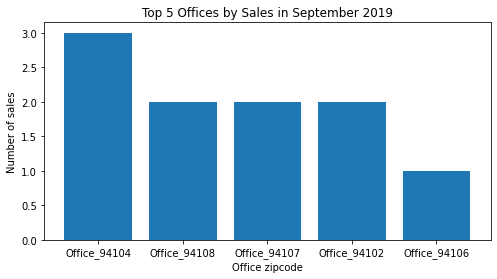

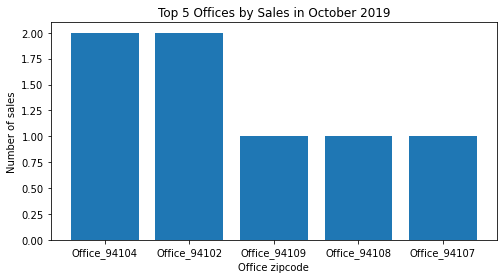

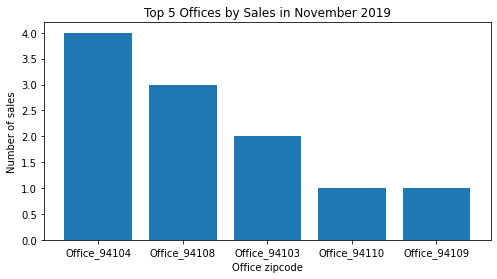

In [999]:
count = func.count(ListedHouses.office_id).label("Count")

for i in range(1,12):
    top_5_offices = session.query(Sales.id, Offices.name, count)\
        .filter(Sales.sale_date.between(datetime(2019,i,1),datetime(2019,i+1,1)))\
        .join(ListedHouses, Sales.house_id==ListedHouses.id)\
        .join(Offices, ListedHouses.office_id==Offices.id)\
        .group_by(Offices.id)\
        .order_by(count.desc())\
        .limit(5)\
        .all()
    try:
        x = np.take(np.array(top_5_offices), 1, axis=1)
        y = [int(i) for i in np.take(np.array(top_5_offices), 2, axis=1)]
    except:
        x = 'None'
        y = 0
    
    plt.figure(figsize=(8,4))
    plt.bar(x,y)
    plt.title(f"Top 5 Offices by Sales in {calendar.month_name[i]} 2019")
    plt.xlabel("Office zipcode")
    plt.ylabel("Number of sales")
    plt.show()

Note: This data describes a company that only began listing housees in January 2019, and my implementation simulates sale date anywhere from 5 to 90 days after listing date based on rough research and personal experience. Thus, there aren't immediately listings in the beginning and only a few offices make sales at all some months, sometimes less than 5.

#### 2. Find the top 5 estate agents who have sold the most (include their contact details and their sales details so that it is easy contact them and congratulate them).

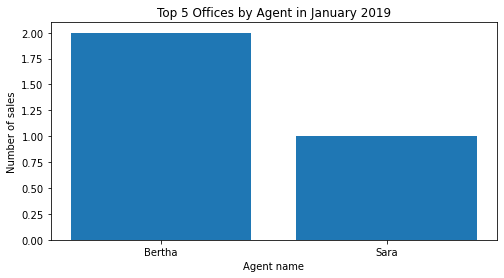

Name: Bertha, Email Address: Bertha@yahoo.com, Sales: 2
Name: Sara, Email Address: Sara@yahoo.com, Sales: 1



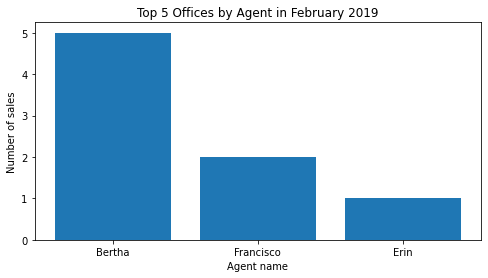

Name: Bertha, Email Address: Bertha@yahoo.com, Sales: 5
Name: Francisco, Email Address: Francisco@yahoo.com, Sales: 2
Name: Erin, Email Address: Erin@yahoo.com, Sales: 1



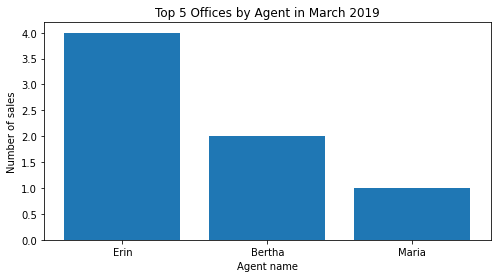

Name: Erin, Email Address: Erin@yahoo.com, Sales: 4
Name: Bertha, Email Address: Bertha@yahoo.com, Sales: 2
Name: Maria, Email Address: Maria@yahoo.com, Sales: 1



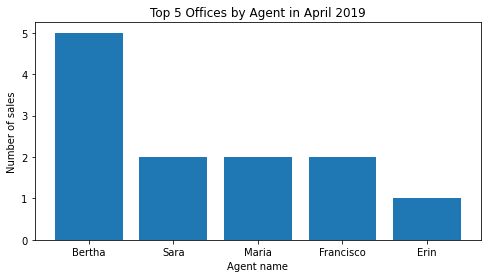

Name: Bertha, Email Address: Bertha@yahoo.com, Sales: 5
Name: Sara, Email Address: Sara@yahoo.com, Sales: 2
Name: Maria, Email Address: Maria@yahoo.com, Sales: 2
Name: Francisco, Email Address: Francisco@yahoo.com, Sales: 2
Name: Erin, Email Address: Erin@yahoo.com, Sales: 1



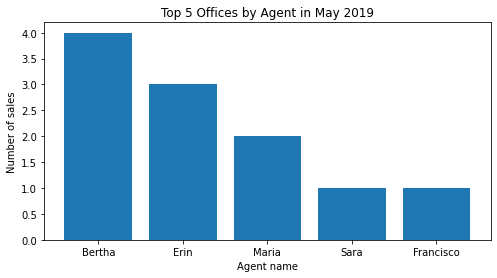

Name: Bertha, Email Address: Bertha@yahoo.com, Sales: 4
Name: Erin, Email Address: Erin@yahoo.com, Sales: 3
Name: Maria, Email Address: Maria@yahoo.com, Sales: 2
Name: Sara, Email Address: Sara@yahoo.com, Sales: 1
Name: Francisco, Email Address: Francisco@yahoo.com, Sales: 1



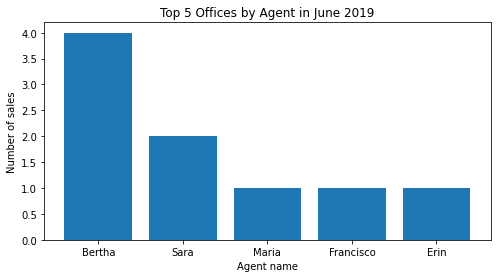

Name: Bertha, Email Address: Bertha@yahoo.com, Sales: 4
Name: Sara, Email Address: Sara@yahoo.com, Sales: 2
Name: Maria, Email Address: Maria@yahoo.com, Sales: 1
Name: Francisco, Email Address: Francisco@yahoo.com, Sales: 1
Name: Erin, Email Address: Erin@yahoo.com, Sales: 1



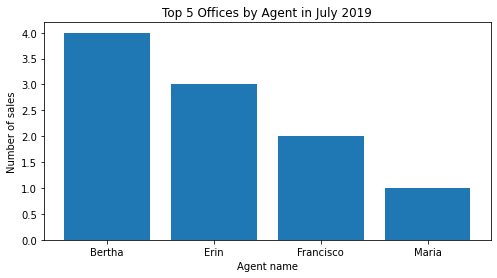

Name: Bertha, Email Address: Bertha@yahoo.com, Sales: 4
Name: Erin, Email Address: Erin@yahoo.com, Sales: 3
Name: Francisco, Email Address: Francisco@yahoo.com, Sales: 2
Name: Maria, Email Address: Maria@yahoo.com, Sales: 1



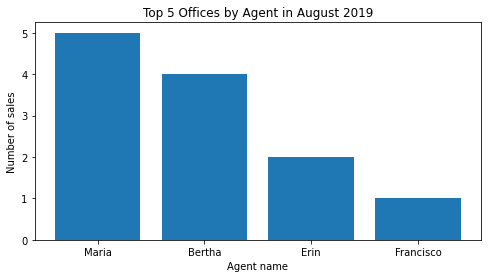

Name: Maria, Email Address: Maria@yahoo.com, Sales: 5
Name: Bertha, Email Address: Bertha@yahoo.com, Sales: 4
Name: Erin, Email Address: Erin@yahoo.com, Sales: 2
Name: Francisco, Email Address: Francisco@yahoo.com, Sales: 1



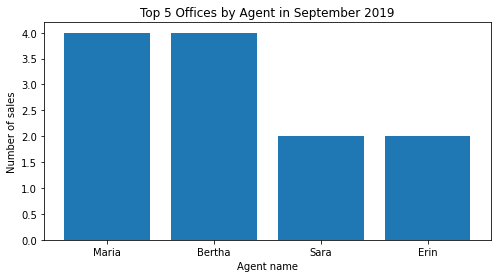

Name: Maria, Email Address: Maria@yahoo.com, Sales: 4
Name: Bertha, Email Address: Bertha@yahoo.com, Sales: 4
Name: Sara, Email Address: Sara@yahoo.com, Sales: 2
Name: Erin, Email Address: Erin@yahoo.com, Sales: 2



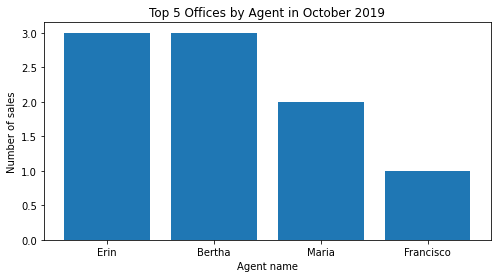

Name: Erin, Email Address: Erin@yahoo.com, Sales: 3
Name: Bertha, Email Address: Bertha@yahoo.com, Sales: 3
Name: Maria, Email Address: Maria@yahoo.com, Sales: 2
Name: Francisco, Email Address: Francisco@yahoo.com, Sales: 1



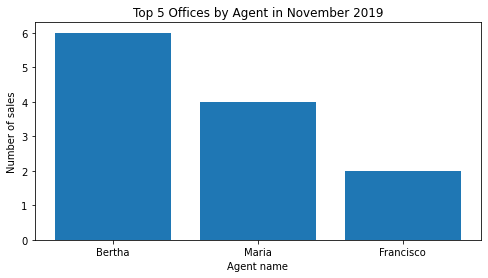

Name: Bertha, Email Address: Bertha@yahoo.com, Sales: 6
Name: Maria, Email Address: Maria@yahoo.com, Sales: 4
Name: Francisco, Email Address: Francisco@yahoo.com, Sales: 2



In [1000]:
count = func.count(ListedHouses.office_id).label("Count")

for i in range(1,12):
    top_5_agents = session.query(Sales.id, Agents.name, Agents.email_address, count)\
        .filter(Sales.sale_date.between(datetime(2019,i,1),datetime(2019,i+1,1)))\
        .join(ListedHouses, Sales.house_id==ListedHouses.id)\
        .join(Agents, ListedHouses.office_id==Agents.id)\
        .group_by(Agents.name)\
        .order_by(count.desc())\
        .limit(5)\
        .all()
    
    try:
        x = [str(agent) for agent in np.take(np.array(top_5_agents), 1, axis=1)]
        y = [int(count) for count in np.take(np.array(top_5_agents), 3, axis=1)]
    except:
        x = 'None'
        y = 0
    

    plt.figure(figsize=(8,4))
    plt.bar(x,y)
    plt.title(f"Top 5 Offices by Agent in {calendar.month_name[i]} 2019")
    plt.xlabel("Agent name")
    plt.ylabel("Number of sales")
    plt.show()
    
    print(''.join(f"Name: {agent[1]}, Email Address: {agent[2]}, Sales: {agent[3]}\n" for agent in top_5_agents))

Note: Similarly, few agents make any sales at all some months, sometimes less than 5.

#### 3. Calculate the commission that each estate agent must receive and store the results in a separate table.

In [1001]:
'''
Apply given rules of commission
'''

Session = sessionmaker(bind=engine)
session = Session()

# Add Commission for every Sale
for s in session.query(Sale).all():

    p = s.sale_price
    
    if p < 100000:
        percent = 0.1
    elif p > 100000 and p <= 200000:
        percent = 0.075
    elif p > 200000 and p <= 500000:
        percent = 0.06
    elif p > 500000 and p <= 1000000:
        percent = 0.05
    elif p > 1000000:
        percent = 0.04
    
    session.add(Commission(agent_id=session.query(ListedHouse).all()[s.house_id-1].agent_id,
                           commission=round(percent*float(p), 2)))

try:
    session.commit()

except:
    session.rollback()
    raise

finally:
    session.close()

In [1002]:
# Calculate Total Commission for every Agent
comm = func.sum(Commissions.commission).label("SumCommission")

session.query(Commissions.id, Agents.name, Commissions.commission)\
    .join(Agents, Commissions.agent_id==Agents.id)\
    .group_by(Agents.name)\
    .all()

[(2, 'Bertha', 31790.85),
 (5, 'Carolyn', 15789.6),
 (31, 'Debrah', 43629.3),
 (11, 'Erin', 45006),
 (4, 'Francisco', 14370.7),
 (14, 'Jason', 26841.6),
 (3, 'Joe', 22821.12),
 (1, 'Karen', 28541.74),
 (9, 'Maria', 17001.6),
 (8, 'Sara', 40501.5)]

#### 4. For all houses that were sold that month, calculate the average number of days that the house was on the market.

In [1038]:
for i in range(1,12):
    monthly_sales = session.query(Sales.id, ListedHouses.list_date, Sales.sale_date)\
        .filter(Sales.sale_date.between(datetime(2019,i,1),datetime(2019,i+1,1)))\
        .join(ListedHouses, Sales.house_id==ListedHouses.id)\
        .all()
    
    print(f"{calendar.month_name[i]} Average Listing Time: {round(np.mean([(sale[2]-sale[1]).days for sale in monthly_sales]), 2)}")


January Average Listing Time: 9.67
February Average Listing Time: 23.88
March Average Listing Time: 39.29
April Average Listing Time: 48.33
May Average Listing Time: 47.91
June Average Listing Time: 40.22
July Average Listing Time: 61.0
August Average Listing Time: 48.67
September Average Listing Time: 40.33
October Average Listing Time: 56.89
November Average Listing Time: 46.83


#### 5. For all houses that were sold that month, calculate the average selling price

In [1043]:
for i in range(1,12):
    monthly_sales = session.query(Sales.sale_price)\
        .filter(Sales.sale_date.between(datetime(2019,i,1),datetime(2019,i+1,1)))\
        .all()
    
    print(f"{calendar.month_name[i]} Average Selling Price: {round(np.mean([sale for sale in monthly_sales]), 2)}")


January Average Selling Price: 379802.58
February Average Selling Price: 546604.53
March Average Selling Price: 537030.36
April Average Selling Price: 469499.48
May Average Selling Price: 518495.45
June Average Selling Price: 436169.28
July Average Selling Price: 574760.52
August Average Selling Price: 368937.58
September Average Selling Price: 489017.73
October Average Selling Price: 382410.22
November Average Selling Price: 431153.94


#### 6. Find the zip codes with the top 5 average sales prices

In [1047]:
session.query(Sales.id, Offices.zipcode, count)\
        .filter(Sales.sale_date.between(datetime(2019,4,1),datetime(2019,5,1)))\
        .join(ListedHouses, Sales.house_id==ListedHouses.id)\
        .join(Offices, ListedHouses.office_id==Office.id)\
        .group_by(Offices.zipcode)\
        .order_by(count.desc())\
        .limit(5)\
        .all()

[(22, 94103, 3), (11, 94109, 2), (4, 94105, 2), (24, 94104, 2), (32, 94108, 1)]

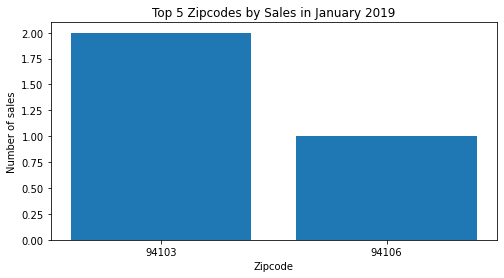

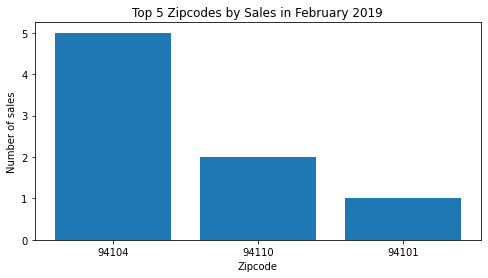

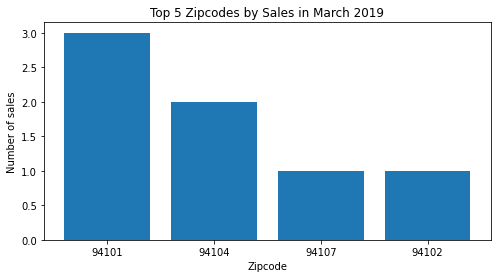

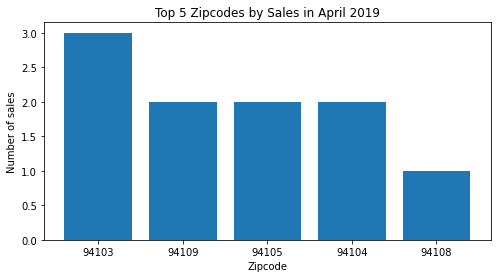

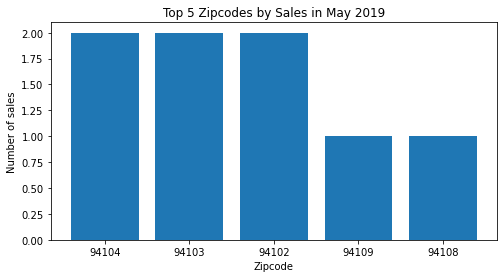

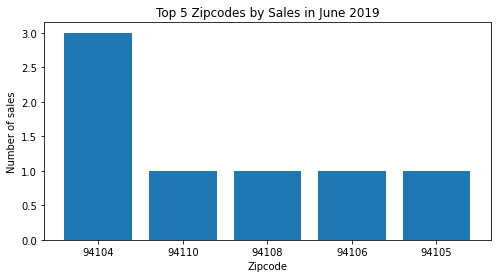

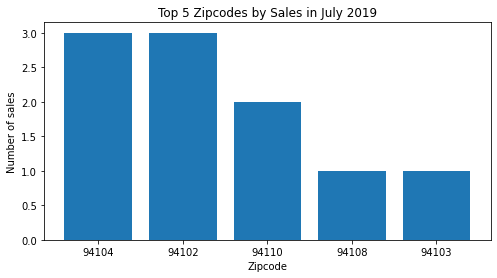

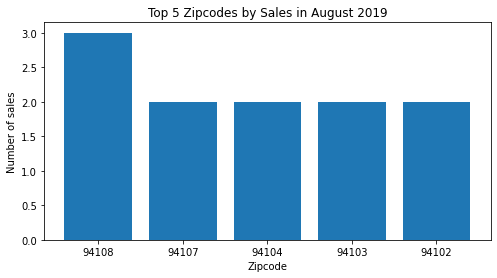

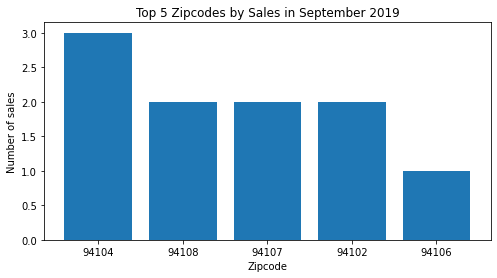

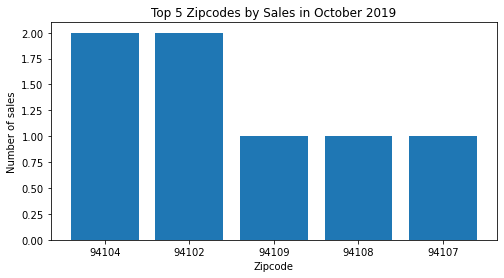

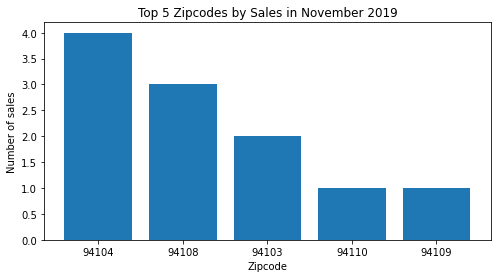

In [1050]:
count = func.count(ListedHouses.office_id).label("Count")

for i in range(1,12):
    top_5_offices = session.query(Sales.id, Offices.zipcode, count)\
        .filter(Sales.sale_date.between(datetime(2019,i,1),datetime(2019,i+1,1)))\
        .join(ListedHouses, Sales.house_id==ListedHouses.id)\
        .join(Offices, ListedHouses.office_id==Offices.id)\
        .group_by(Offices.id)\
        .order_by(count.desc())\
        .limit(5)\
        .all()
    try:
        x = [str(i) for i in np.take(np.array(top_5_offices), 1, axis=1)]
        y = [int(i) for i in np.take(np.array(top_5_offices), 2, axis=1)]
    except:
        x = 'None'
        y = 0
    
    plt.figure(figsize=(8,4))
    plt.bar(x,y)
    plt.title(f"Top 5 Zipcodes by Sales in {calendar.month_name[i]} 2019")
    plt.xlabel("Zipcode")
    plt.ylabel("Number of sales")
    plt.show()

Note: I have implemented my data such that the company has one office per zipcode, thus my solution for Report #6 is the same as my solution for Report #1.

# Appendix: Random Data Generation

In [42]:
# Generate offices for every agent
agent_offices = {}
for i in range(10):
    offices = []
    for j in range(random.randint(1,3)):
        office = random.randint(1,10)
        if office in offices:
            continue
        else:
            offices.append(office)
    agent_offices[i] = offices
        
agent_offices

{0: [4],
 1: [9, 3, 4],
 2: [2, 4, 8],
 3: [6, 5, 4],
 4: [7, 2],
 5: [1, 2, 3],
 6: [10, 4, 3],
 7: [2],
 8: [8],
 9: [7, 8]}

In [967]:
import itertools

agent_count = len([elem for minilist in list(itertools.chain(agent_offices.values())) for elem in minilist])

In [968]:
[elem for minilist in list(itertools.chain(agent_offices.values())) for elem in minilist]

[4, 9, 3, 4, 2, 4, 8, 6, 5, 4, 7, 2, 1, 2, 3, 10, 4, 3, 2, 8, 7, 8]

In [76]:
# Generate rating for every zipcode:
zipcode_rating = {}
for i in range(94101, 94111):
    zipcode_rating[i] = random.randint(3,10)

zipcode_rating

{94101: 9,
 94102: 6,
 94103: 10,
 94104: 4,
 94105: 6,
 94106: 6,
 94107: 8,
 94108: 10,
 94109: 6,
 94110: 9}

In [969]:
import random
import scipy
# Data simulation
'''
Created a function as it would be too tedious to manually create
enough data to fit the task description
'''

# Around 20 per month
def list_house(list_date):
    
    agent_id = random.randint(1,agent_count)
    offices = [elem for minilist in list(itertools.chain(agent_offices.values())) for elem in minilist]
    office_id = offices[agent_id-1]
    size = random.randint(1500,2500) # in square feet
    bedroom_count = random.randint(1,3)
    bathroom_count = random.randint(1,2)
    zipcode = random.randint(94101, 94110)
    condition = random.randint(5,10)
    
    '''
    Price is a function of size, bedroom_count, bathroom_count, zipcode, condition

    Base price in San Francisco: $1000 per square foot
    https://www.businessinsider.com/san-francisco-housing-market-facts-rent-2019-5
    
    San Francisco prices are indeed, inhumanely expensive, 
    and I have tried my best with researched estimations
    to replicate actual prices given details about the house
    but because the assignment implies that houses be at least 100,000
    I have halved the prices
    '''
    
    reasonable = False
    while reasonable == False:
        price = 100001
        if price > 100000:
            price = 0.25*int((size*1000)*((bedroom_count+3)/6)*(bathroom_count+3/5)*(zipcode_rating[zipcode]/10)*(condition/10))
            reasonable = True
        else:
            continue

    return {'agent_id': agent_id, 
            'office_id': office_id, 
            'size': size, 
            'bedroom_count': bedroom_count, 
            'bathroom_count': bathroom_count, 
            'zipcode': zipcode, 
            'condition': condition, 
            'price': price,
            'list_date': list_date}

In [970]:
# Random date generator
# https://kite.com/python/answers/how-to-generate-a-random-date-between-two-dates-in-python

import datetime
import random

def date_generator(start_month, end_month):
    if start_month != 12:
        start_date = datetime.date(2019, start_month, 1)
        end_date = datetime.date(2019, end_month, 1)
    else:
        start_date = datetime.date(2019, start_month, 1)
        end_date = datetime.date(2019, start_month, 31)
    
    time_between_dates = end_date - start_date
    days_between_dates = time_between_dates.days
    random_number_of_days = random.randrange(days_between_dates)
    random_date = start_date + datetime.timedelta(days=random_number_of_days)

    return random_date

In [971]:
# Final random data generator

dates = []
for month in range(1,13):
    for j in range(random.randint(10,20)):
        dates.append(date_generator(month, month+1))
dates.sort()

data = []
for date in dates:
    data.append(list_house(date))

data

[{'agent_id': 3,
  'office_id': 3,
  'size': 1875,
  'bedroom_count': 2,
  'bathroom_count': 1,
  'zipcode': 94101,
  'condition': 9,
  'price': 506250.0,
  'list_date': datetime.date(2019, 1, 1)},
 {'agent_id': 18,
  'office_id': 3,
  'size': 2287,
  'bedroom_count': 1,
  'bathroom_count': 2,
  'zipcode': 94106,
  'condition': 8,
  'price': 475695.75,
  'list_date': datetime.date(2019, 1, 4)},
 {'agent_id': 1,
  'office_id': 4,
  'size': 2192,
  'bedroom_count': 2,
  'bathroom_count': 1,
  'zipcode': 94106,
  'condition': 6,
  'price': 263040.0,
  'list_date': datetime.date(2019, 1, 6)},
 {'agent_id': 4,
  'office_id': 4,
  'size': 2329,
  'bedroom_count': 1,
  'bathroom_count': 2,
  'zipcode': 94110,
  'condition': 7,
  'price': 635817.0,
  'list_date': datetime.date(2019, 1, 7)},
 {'agent_id': 15,
  'office_id': 3,
  'size': 2264,
  'bedroom_count': 1,
  'bathroom_count': 1,
  'zipcode': 94110,
  'condition': 7,
  'price': 380352.0,
  'list_date': datetime.date(2019, 1, 9)},
 {'agen